In [1]:
import mne
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from pingouin import partial_corr, corr
from sympy.utilities.iterables import multiset_permutations

from utils import translate, get_average, read_annotations, no_channels_read_annotations, save_to_json
from errors import OutOfSizeError

class Patient:


    def __init__(self, edf_file,
                 annotations,
                 path_to_visual_outputs,
                 path_to_ica_matrix,
                 path_to_results,
                 window_length,
                 ignore_channels,
                 precomputed_ica,
                 chosen_components):

        self.SEED = 97

        self.chosen_components = chosen_components

        print("CHOSEN COMPONENTS", self.chosen_components)

        self.window_to_detect = window_length
        self.precomputed_ica = precomputed_ica

        self.raw = mne.io.read_raw_edf(edf_file)
        self.raw_data = self.raw.get_data()
        self.fs = self.raw.info['sfreq']
        self.ch_names = self.raw.ch_names

        if not ignore_channels:
            self.annotations = read_annotations(annotations)
        else:
            self.annotations = no_channels_read_annotations(annotations,
                                                            fs = self.fs,
                                                            window=window_length,
                                                            max_length=self.raw_data.shape[1])

        self.path_to_visual_outputs = path_to_visual_outputs
        self.path_to_results = path_to_results
        self.path_to_ica_matrix = path_to_ica_matrix



    def quantify_annotations(self):

        for k in self.annotations:
            print('Channel ', k, 'with ', len(self.annotations[k]), 'markings')

        self.all_markings = set()
        for timestamps in self.annotations:
            self.all_markings = self.all_markings.union(set(self.annotations[timestamps]))
        print("Total number of markings", len(self.all_markings))


        general_info = {'fs':self.fs,
                        'number of markings':len(self.all_markings)}

        save_to_json(self.path_to_results+'/general_info.json', general_info)

    def run_ica(self, variability_explained=0.95):
        '''
        Function that runs the ICA algorithm on the raw data. Saves the decomposed sources into the variable self.ica_sources_data
        :param variability_explained: float
        '''
        if self.precomputed_ica:
            self.ica_sources_data = np.load(self.path_to_ica_matrix+'/ica_matrix.npy')

            self.ica_sources_ch_names = []
            with open(self.path_to_ica_matrix+"/component_names.txt", "r") as f:
                for line in f:
                    self.ica_sources_ch_names.append(line.strip())

        else:
            ica = mne.preprocessing.ICA(n_components=variability_explained, random_state=self.SEED)
            ica.fit(self.raw)

            ica_sources = ica.get_sources(self.raw)
            self.ica_sources_ch_names = ica_sources.ch_names
            self.ica_sources_data = ica_sources.get_data()

            np.save(self.path_to_ica_matrix+'/ica_matrix.npy', self.ica_sources_data)

            with open(self.path_to_ica_matrix+"/component_names.txt", "w") as f:
                for s in self.ica_sources_ch_names:
                    f.write(str(s) + "\n")

            self.precomputed_ica = True

    def no_channels_during_seizures_states(self):
        '''
        The function is used to derive and save the patient's state during IEDs into  a dictionary: self.per_component_state_during_seizures
        Function stores the state of all channels and componets before and after IED in scope of a window
        Created for analysis of channels with no prior text-processing
        :return:
        '''

        per_channel_ieds, per_component_state_during_seizures = {}, {}

        for i, channel in enumerate(self.ch_names):

            data = self.raw_data[i]
            for timestamp in self.all_markings:
                pointer = timestamp

                ranged_data = data[pointer - self.window_to_detect:pointer + self.window_to_detect]

                if len(ranged_data) != self.window_to_detect * 2:
                    raise OutOfSizeError(pointer)

                if channel not in per_channel_ieds.keys():
                    per_channel_ieds[channel] = [ranged_data]
                else:
                    per_channel_ieds[channel].append(ranged_data)

        self.per_channel_ieds = per_channel_ieds

        if self.precomputed_ica:

            for i, ch in enumerate(self.ica_sources_ch_names):

                data = self.ica_sources_data[i]

                for timestamp in self.all_markings:

                    pointer = timestamp

                    ranged_data = data[pointer - self.window_to_detect:pointer + self.window_to_detect]

                    if ch not in per_component_state_during_seizures.keys():
                        per_component_state_during_seizures[ch] = [ranged_data]
                    else:
                        per_component_state_during_seizures[ch].append(ranged_data)

            self.per_channel_ieds, self.per_component_state_during_seizures = per_channel_ieds, per_component_state_during_seizures

    # def during_ieds_states(self):
    #     '''
    #     The function is used to derive and save the patient's state during IEDs into  a dictionary: self.per_component_state_during_seizures
    #     :return:
    #     '''
    #     per_channel_ieds, per_component_state_during_seizures = {}, {}
    #
    #     print("Text-processed channels:")
    #     # Some channels are not text-processed conviniently and need the following text-processing
    #     for channel in self.annotations:
    #         print(channel)
    #
    #         try:
    #             for ch_raw in self.ch_names:
    #                 if channel.upper() in ch_raw and channel not in per_channel_ieds.keys():
    #                     channel = ch_raw
    #
    #             data = self.raw_data[self.ch_names.index(channel.upper())]
    #         except:
    #             continue
    #
    #         for timestamp in self.annotations[channel[:3]]:
    #
    #             pointer = int(timestamp * self.fs)
    #
    #             ranged_data = data[pointer - self.window_to_detect:pointer + self.window_to_detect]
    #
    #             if channel not in per_channel_ieds.keys():
    #                 per_channel_ieds[channel] = [ranged_data]
    #             else:
    #                 per_channel_ieds[channel].append(ranged_data)
    #
    #     for i, ch in enumerate(self.ica_sources_ch_names):
    #
    #         data = self.ica_sources_data[i]
    #
    #         for timestamp in self.all_markings:
    #             pointer = int(timestamp * self.fs)
    #
    #             ranged_data = data[pointer - self.window_to_detect:pointer + self.window_to_detect]
    #
    #             if ch not in per_component_state_during_seizures.keys():
    #                 per_component_state_during_seizures[ch] = [ranged_data]
    #             else:
    #                 per_component_state_during_seizures[ch].append(ranged_data)
    #
    #     self.per_channel_ieds, self.per_component_state_during_seizures = per_channel_ieds, per_component_state_during_seizures

    def normalize_components(self):
        '''
        The function is used to normalize the components, s.t. while visualizing they will be comparable to the signal on the electrodes during IEDs.
        '''
        normalized_per_component_states = {}
        leftMin, leftMax = np.min(self.ica_sources_data), np.max(self.ica_sources_data)
        rightMin, rightMax = np.min(self.raw_data), np.max(self.raw_data)

        for c in self.per_component_state_during_seizures:
            result = []

            for seizure in self.per_component_state_during_seizures[c]:
                normalized_seizure = []
                for el in seizure:
                    normalized_seizure.append(translate(el, leftMin, leftMax, rightMin, rightMax))
                result.append(normalized_seizure)
            normalized_per_component_states[c] = np.array(result)

        self.normalized_per_component_states = normalized_per_component_states

    def plot_all_components_during_seizures(self, savefigures=False):
        '''
        The function is used to plot the states of the components during all the IEDs.
        '''

        for channel in self.per_channel_ieds:

            average_signal, signal_stdev = get_average(self.per_channel_ieds[channel])
            # print("N.o. events on this channel", len(self.per_channel_ieds[channel]))
            duration_timestamp = [i - self.window_to_detect for i in range(len(average_signal))]

            fig = plt.figure(figsize=(24, 10))

            plt.plot(duration_timestamp, average_signal, lw=3, label='pattern')
            lower_bound = average_signal - signal_stdev
            upper_bound = average_signal + signal_stdev
            plt.fill_between(duration_timestamp, lower_bound, upper_bound, facecolor='lightyellow', alpha=0.5,
                             label='1 sigma range')

            plt.title("Channel " + str(channel), fontsize=23)

            for component in self.normalized_per_component_states:
                average_component, component_stdev = get_average(self.normalized_per_component_states[component])

                plt.plot(duration_timestamp, average_component, lw=1, label=component)

            plt.title("Channel " + str(channel), fontsize=23)
            plt.legend()
            if savefigures:
                plt.savefig(self.path_to_visual_outputs+'/all_components/ch_'+str(channel)+'.jpg')
            plt.close()

    def plot_selected_components_during_seizures(self, potentially_significant, savefigures = False):
        '''
        The function plots channels stated as well as states on selected components during IEDs.
        :param potentially_significant: list(str)
        '''
        for i, channel in enumerate(self.per_channel_ieds):

            if i < 2:
                print('i=',i, 'channel', channel)

                average_signal, signal_stdev = get_average(self.per_channel_ieds[channel])
                # print('number of')
                duration_timestamp = [i for i in range(len(average_signal))]

                fig = plt.figure(figsize=(24, 10))

                plt.plot(duration_timestamp, average_signal, lw=3, label='pattern')
                lower_bound = average_signal - signal_stdev
                upper_bound = average_signal + signal_stdev
                plt.fill_between(duration_timestamp, lower_bound, upper_bound, facecolor='lightyellow', alpha=0.5,
                                 label='1 sigma range')

                for component in self.normalized_per_component_states:

                    if component in potentially_significant:
                        average_component, component_stdev = get_average(self.normalized_per_component_states[component])
                        plt.plot(duration_timestamp, average_component, lw=1, label=component)

                plt.title("Channel " + str(channel), fontsize=23)
                plt.legend()

                if savefigures:
                    plt.savefig(self.path_to_visual_outputs+'/significant_components/ch_'+str(channel)+'.jpg')
                plt.close()


    def plot_components_during_seizures_nochannels(self, potentially_significant=False, savefigures = False):
        '''
        The function plots only selected components during IEDs.
        :param potentially_significant: list(str)
        '''
        if potentially_significant:
            fig = plt.figure(figsize=(24, 10))
            plt.title('Average components state during seizures', fontsize=23)
            for component in self.per_component_state_during_seizures:
                if component in potentially_significant:
                    average_component, component_stdev = get_average(
                        self.normalized_per_component_states[component])
                    duration_timestamp = [i for i in range(len(average_component))]
                    plt.plot(duration_timestamp, average_component, lw=1, label=component)

            if savefigures:
                plt.savefig(self.path_to_visual_outputs + '/potentially_significant_during_seizures.jpg')
            plt.close()

        else:
            fig = plt.figure(figsize=(24, 10))
            plt.title('Average components state during seizures', fontsize=23)
            for component in self.per_component_state_during_seizures:
                average_component, component_stdev = get_average(self.normalized_per_component_states[component])
                duration_timestamp = [i for i in range(len(average_component))]
                plt.plot(duration_timestamp, average_component, lw=1, label=component)

            if savefigures:
                plt.savefig(self.path_to_visual_outputs + '/all_components_during_seizures.jpg')
            plt.close()

    def plot_on_channel(self, ch_index_list, savefigures = False):

        fig = plt.figure(figsize=(24, 10))

        for i, channel in enumerate(self.per_channel_ieds):

            if i in ch_index_list or channel in ch_index_list:
                print("Channel ", channel)

                average_signal, signal_stdev = get_average(self.per_channel_ieds[channel])

                duration_timestamp = [i - self.window_to_detect for i in range(len(average_signal))]

                fig = plt.figure(figsize=(24, 10))

                plt.plot(duration_timestamp, average_signal, lw=3, label='pattern')
                lower_bound = average_signal - signal_stdev
                upper_bound = average_signal + signal_stdev
                plt.fill_between(duration_timestamp, lower_bound, upper_bound, facecolor='lightyellow', alpha=0.5,
                                 label='1 sigma range')

                plt.title("Channel " + str(channel), fontsize=23)

        if savefigures:
            plt.savefig(self.path_to_visual_outputs + '/selected_channels'+str(ch_index_list)+'.jpg')
        plt.close()

    def get_significant_components_state(self, potentially_significant):
            '''
            After the significant components were manually chosen,
            this function saves them into one variable stored withing an object of a class.
            :param potentially_significant: list(str)
            '''
            self.significant_components = {}

            for component in self.normalized_per_component_states:
                if component in potentially_significant:
                    self.significant_components[component] = self.normalized_per_component_states[component]


            for i in self.significant_components:
                f = '/home/garkots/invasive_eeg/analysis/results/experiment_window_100/pat4/wake/significant_components_' + str(
                    i) + '.npy'
                np.save(f, self.significant_components[i])




    def run_causal_inference(self, no_combination=None):
        '''
        The function runs the causal analysis on the extracted components. If the n.o. components of choice exceeds 3,
         all of the possible combinations by no_combination variable (recomennded = 3) are checked from the list.
        :param no_combination: int
        :return:
        '''
        if no_combination:
            possible_combinations = [p for p in multiset_permutations([i for i in self.significant_components.keys()],
                                                                      no_combination)]
        else:
            possible_combinations = [p for p in multiset_permutations([i for i in self.significant_components.keys()])]

        results = {}
        taus = [i for i in range(self.window_to_detect)]

        pval_min_threshold, pval_max_threshold = 0.08, 0.08

        for combination in possible_combinations:
            print('combination', combination)
            key_combination = tuple(combination)

            results[key_combination] = {}

            for tau in tqdm(taus):

                for t0 in range(self.window_to_detect * 2 - tau * 2):

                    x = self.significant_components[key_combination[0]][:, t0]
                    y = self.significant_components[key_combination[1]][:, t0 + tau * 2]
                    z = self.significant_components[key_combination[2]][:, t0 + tau]

                    data1 = pd.DataFrame({'x': x, 'y': y, 'covar': z})

                    pc = partial_corr(data1, 'x', 'y', 'covar')

                    correlation = corr(data1['x'], data1['y']).round(3)

                    if pc['p-val'][0] > pval_max_threshold:
                        if correlation['p-val'][0] < pval_min_threshold:
                            if tau in results[key_combination].keys():
                                results[key_combination][tau].append(t0)
                            else:

                                results[key_combination][tau] = [t0]

        self.per_combination_frequency = results


    def visualize_per_Tau_frequency(self, tau, savefigures = False):
        '''
        The function plots tick-plot for every causal event detected relative to an IED time for every possible combination of channels.
        :param tau: int
        :return:
        '''
        fig = plt.figure(figsize=(10, 10))
        timescale = list([i for i in range(-self.window_to_detect, self.window_to_detect)])
        plt.title("τ = " + str(tau))
        fixed_tau = tau
        Y_Tick_List = []
        Y_Tick_Label_List = []

        for indx, schema in enumerate(self.per_combination_frequency):

            plt.plot(timescale, list([indx * 10 for k in range(2*self.window_to_detect)]), label=schema[0] + ' -> ' + schema[2])
            Y_Tick_List.append(indx * 10)
            Y_Tick_Label_List.append(schema[0] + ' -> ' + schema[2])

            if fixed_tau in self.per_combination_frequency[schema].keys():
                all_markings = set([k - self.window_to_detect for k in self.per_combination_frequency[schema][fixed_tau]])
                plt.scatter(list(all_markings), list([indx * 10 for k in range(len(all_markings))]), marker="|")
            else:
                continue

        plt.yticks(ticks=Y_Tick_List, labels=Y_Tick_Label_List, rotation=25, fontsize=8)
        plt.axvline(x=0)

        if savefigures:
            plt.savefig(self.path_to_visual_outputs + '/per_tau_results/tau_'+str(tau)+'.jpg')
        plt.close()


/home/garkots/.conda/envs/garkots/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from tqdm import tqdm
import numpy as np
from scipy.stats import zscore
from antropy import perm_entropy
import matplotlib.pyplot as plt

def deviative_choice(patient, components_vals):

    per_channel_deviation_names = []
    per_channel_deviation_values  = []
    
    for channel in tqdm(patient.per_component_state_during_seizures):
        per_channel_deviation_names.append(channel)
        concatenated = np.concatenate(patient.per_component_state_during_seizures[channel])
        
#         entropy = perm_entropy(concatenated, 5, 5)
        span = np.max(concatenated) - np.min(concatenated)
        variance = np.var(concatenated)
        combined_val =  span + variance
#         print("CH", channel, '=', combined_val)
        components_vals[channel] = combined_val
#         combined_val = entropy - span
        per_channel_deviation_values.append(combined_val )

    per_channel_deviation_values = np.asarray(per_channel_deviation_values)
    per_channel_deviation_names = np.asarray(per_channel_deviation_names)

    indx_val = {}
    for i, val in enumerate(per_channel_deviation_values):
        indx_val[val] = i

    print(per_channel_deviation_values)
#     chosen = list(per_channel_deviation_names[zscore(per_channel_deviation_values) <= -2])

    chosen = list(per_channel_deviation_names[zscore(per_channel_deviation_values) >= 2])


    while len(chosen) < 3:

        sorted_per_channel_deviation_values = np.sort(per_channel_deviation_values)

        for stdev_val in sorted_per_channel_deviation_values:
            if per_channel_deviation_names[indx_val[stdev_val]] not in chosen:
                chosen.append(per_channel_deviation_names[indx_val[stdev_val]])
                break

    return chosen, components_vals


In [3]:
true_components = {
    'pat1': { },
    'pat2': { },
    'pat3': { },
    'pat4': { },
    'pat5': { },
    'pat6' : { },
    'pat7' : { },
    'pat8' : { },
    'pat9' : { },
    'pat10' : { }
}

algos_components = {
    'pat1': { },
    'pat2': { },
    'pat3': { },
    'pat4': { },
    'pat5': { },
    'pat6' : { },
    'pat7' : { },
    'pat8' : { },
    'pat9' : { },
    'pat10' : { }
}

paths = {
    'pat1': { },
    'pat2': { },
    'pat3': { },
    'pat4': {
            'wake': {'path_edf' : '/data/garkots/third_package/pat04_ON_wake/EEG_1277-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat04_ON_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat4/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat4/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat4/wake',
                      'chosen_components' : ['ICA004', 'ICA003', 'ICA007']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat04_ON_sleep/EEG_1278-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat04_ON_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat4/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat4/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat4/sleep',
                      'chosen_components' : ['ICA005', 'ICA003', 'ICA000']
                      }
             },
    'pat5': {
            'wake': {'path_edf' : '/data/garkots/third_package/pat05_OFF_wake/EEG_236-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat05_OFF_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat5/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat5/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat5/wake',
                      'chosen_components' : ['ICA001', 'ICA006', 'ICA011']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat05_OFF_sleep/EEG_1232-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat05_OFF_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat5/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat5/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat5/sleep',
                      'chosen_components' : ['ICA028', 'ICA018', 'ICA032']
                      }
             },
    'pat6' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat06_ON_wake/EEG_1231-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat06_ON_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat6/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat6/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat6/wake',
                      'chosen_components' : ['ICA006','ICA016', 'ICA003', 'ICA008', 'ICA001', 'ICA025']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat06_ON_sleep/EEG_1230-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat06_ON_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat6/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat6/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat6/sleep',
                      'chosen_components' : ['ICA007', 'ICA004', 'ICA024', 'ICA003']
                      }
             },
    
    'pat7' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat07_ON_wake/EEG_1185-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat07_ON_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat7/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat7/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat7/wake',
                      'chosen_components' : ['ICA010', 'ICA023', 'ICA009', 'ICA006']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat07_ON_sleep/pat07_EEG_1181-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat07_ON_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat7/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat7/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat7/sleep',
                      'chosen_components' : ['ICA005', 'ICA008', 'ICA013', 'ICA009', 'ICA006']
                      }
             },
    'pat8' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat08_ON_wake/EEG_1229-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat08_ON_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat8/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat8/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat8/wake',
                      'chosen_components' : ['ICA000', 'ICA001', 'ICA002']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat08_ON_sleep/EEG_1228-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat08_ON_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat8/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat8/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat8/sleep',
                      'chosen_components' : ['ICA000', 'ICA001', 'ICA002']
                      }
             },
    'pat9' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat09_ON_wake/EEG_1227-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat09_ON_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat9/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat9/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat9/wake',
                      'chosen_components' : ['ICA006', 'ICA005', 'ICA000', 'ICA003']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat09_ON_sleep/EEG_1225-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat09_ON_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat9/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat9/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat9/sleep',
                      'chosen_components' : ['ICA004', 'ICA006', 'ICA009', 'ICA012', 'ICA001']
                      }
             },
    'pat10' : {
            'wake': {'path_edf' : '/data/garkots/third_package/pat10_wake/EEG_1222-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat10_wake/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/wake',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/wake',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat10/wake',
                      'chosen_components' : ['ICA010',  'ICA005', 'ICA001']
                      },
             'sleep':{'path_edf' : '/data/garkots/third_package/pat10_sleep/EEG_1221-export.edf',
                      'path_ann' : '/data/garkots/third_package/pat10_sleep/',
                      'path_visual' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/sleep',
                      'path_results' : '/home/garkots/invasive_eeg/analysis/visuals/component_choice/experiment_window_100/pat10/sleep',
                      'path_ica' : '/home/garkots/invasive_eeg/analysis/matrices_ica/pat10/sleep',
                      'chosen_components' : ['ICA009', 'ICA005', 'ICA008']
                      }
             }
}

In [4]:
patients = ['pat4', 'pat5', 'pat6', 'pat7', 'pat8', 'pat9', 'pat10']
def evaluate_performance(func, patients):
    fig, axs = plt.subplots(len(patients), 2)

    for i, p in enumerate(patients):
        for j, s in enumerate(['sleep', 'wake']):
            patient = Patient(edf_file = paths[p][s]['path_edf'],
                 annotations =  paths[p][s]['path_ann'],
                 path_to_visual_outputs= paths[p][s]['path_visual'],
                 path_to_results= paths[p][s]['path_results'],
                 path_to_ica_matrix= paths[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 500,
                 chosen_components =[])
            
            patient.quantify_annotations()
            
            chosen_components = paths[p][s]['chosen_components']
            true_components[p][s] = chosen_components 
            
            components_vals = {}
            
            patient.run_ica()
            patient.no_channels_during_seizures_states()
            patient.normalize_components()
            algos, components_vals = func(patient, components_vals)
            algos_components[p][s] = algos 

            patient.plot_selected_components_during_seizures(potentially_significant=algos, savefigures=True)

            axs[i,j].hist(components_vals.values(), bins = 10, label='total')
            axs[i,j].hist([components_vals[i] for i in algos], bins = 10, color='tab:red', label='chosen by algo')
            axs[i,j].hist([components_vals[i] for i in chosen_components], bins = 10, color='gold', label='chosen manually')
            axs[i,j].legend()
            axs[i,j].set_title('Patient '+p[3:]+' '+s)
            
            fig.show()
    fig.show()
    

In [7]:
def deviative_choice(patient, components_vals):

    per_channel_deviation_names = []
    per_channel_deviation_values  = []
    
    for channel in tqdm(patient.per_component_state_during_seizures):
        per_channel_deviation_names.append(channel)
        concatenated = np.concatenate(patient.per_component_state_during_seizures[channel])
        
#         entropy = perm_entropy(concatenated, 15, 5)
#         span = np.max(concatenated) - np.min(concatenated)
        variance = np.var(concatenated)
        combined_val =  variance
#         print("CH", channel, '=', combined_val)
        components_vals[channel] = combined_val
#         combined_val = entropy - span
        per_channel_deviation_values.append(combined_val )

    per_channel_deviation_values = np.asarray(per_channel_deviation_values)
    per_channel_deviation_names = np.asarray(per_channel_deviation_names)

    indx_val = {}
    for i, val in enumerate(per_channel_deviation_values):
        indx_val[val] = i

    print(per_channel_deviation_values)
#     chosen = list(per_channel_deviation_names[zscore(per_channel_deviation_values) <= -2])

    chosen = list(per_channel_deviation_names[zscore(per_channel_deviation_values) >= 2])


    while len(chosen) < 3:

        sorted_per_channel_deviation_values = np.sort(per_channel_deviation_values)

        for stdev_val in sorted_per_channel_deviation_values:
            if per_channel_deviation_names[indx_val[stdev_val]] not in chosen:
                chosen.append(per_channel_deviation_names[indx_val[stdev_val]])
                break

    return chosen, components_vals

CHOSEN COMPONENTS []
Extracting EDF parameters from /data/garkots/third_package/pat04_ON_sleep/EEG_1278-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel  EEG_1278_EVENTS with  11270 markings
Total number of markings 11269


KeyboardInterrupt: 

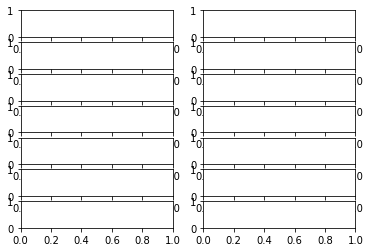

In [8]:
evaluate_performance(deviative_choice, patients)

In [75]:
algos_components

{'pat1': {},
 'pat2': {},
 'pat3': {},
 'pat4': {'sleep': ['ICA011', 'ICA007', 'ICA022'],
  'wake': ['ICA004', 'ICA000', 'ICA001']},
 'pat5': {'sleep': ['ICA010', 'ICA028', 'ICA012'],
  'wake': ['ICA001', 'ICA024', 'ICA004']},
 'pat6': {'sleep': ['ICA007', 'ICA019', 'ICA023'],
  'wake': ['ICA003', 'ICA016', 'ICA007']},
 'pat7': {'sleep': ['ICA006', 'ICA015', 'ICA014'],
  'wake': ['ICA009', 'ICA016', 'ICA011']},
 'pat8': {'sleep': ['ICA000', 'ICA001', 'ICA002'],
  'wake': ['ICA000', 'ICA002', 'ICA001']},
 'pat9': {'sleep': ['ICA011', 'ICA005', 'ICA013'],
  'wake': ['ICA000', 'ICA001', 'ICA004']},
 'pat10': {'sleep': ['ICA014', 'ICA002', 'ICA010'],
  'wake': ['ICA017', 'ICA010', 'ICA007']}}

In [76]:
true_components

{'pat1': {},
 'pat2': {},
 'pat3': {},
 'pat4': {'sleep': ['ICA005', 'ICA003', 'ICA000'],
  'wake': ['ICA004', 'ICA003', 'ICA007']},
 'pat5': {'sleep': ['ICA028', 'ICA018', 'ICA032'],
  'wake': ['ICA001', 'ICA006', 'ICA011']},
 'pat6': {'sleep': ['ICA007', 'ICA004', 'ICA024', 'ICA003'],
  'wake': ['ICA006', 'ICA016', 'ICA003', 'ICA008', 'ICA001', 'ICA025']},
 'pat7': {'sleep': ['ICA005', 'ICA008', 'ICA013', 'ICA009', 'ICA006'],
  'wake': ['ICA010', 'ICA023', 'ICA009', 'ICA006']},
 'pat8': {'sleep': ['ICA000', 'ICA001', 'ICA002'],
  'wake': ['ICA000', 'ICA001', 'ICA002']},
 'pat9': {'sleep': ['ICA004', 'ICA006', 'ICA009', 'ICA012', 'ICA001'],
  'wake': ['ICA006', 'ICA005', 'ICA000', 'ICA003']},
 'pat10': {'sleep': ['ICA009', 'ICA005', 'ICA008'],
  'wake': ['ICA010', 'ICA005', 'ICA001']}}

In [77]:
for p in true_components:
    for s in true_components[p]:
        print(p, s)
        print( len(set(true_components[p][s]).intersection(set(algos_components[p][s])))/len(set(true_components[p][s])) )

pat4 sleep
0.0
pat4 wake
0.3333333333333333
pat5 sleep
0.3333333333333333
pat5 wake
0.3333333333333333
pat6 sleep
0.25
pat6 wake
0.3333333333333333
pat7 sleep
0.2
pat7 wake
0.25
pat8 sleep
1.0
pat8 wake
1.0
pat9 sleep
0.0
pat9 wake
0.25
pat10 sleep
0.0
pat10 wake
0.3333333333333333


In [30]:
def get_average(arrays):
    # arrays --> list of lists, where every list is a cropped IED on a Signal

    result = []
    stdevs = []

    # iterating over every count
    for enrty_indx in range(len(arrays[0])):

        # we will record average summing the corresponding counts
        to_get_average = []

        # iterating over every component
        for i in range(len(arrays)):
            # get the state
            state = arrays[i]

            to_get_average.append(state[enrty_indx])

        result.append(sum(to_get_average) / len(to_get_average))
        stdevs.append(np.std(to_get_average))

    return np.array(result), np.array(stdevs)

In [51]:
def deviative_choice(patient, components_vals):

    per_channel_deviation_names = []
    per_channel_deviation_values  = []
    
    for channel in tqdm(patient.normalized_per_component_states):
        per_channel_deviation_names.append(channel)
        avg, stdev = get_average(patient.normalized_per_component_states[channel])
        
        span = np.max(avg) - np.min(avg)
        variance = np.var(avg)
        combined_val =  span + variance
        components_vals[channel] = combined_val
        per_channel_deviation_values.append(combined_val )

    per_channel_deviation_values = np.asarray(per_channel_deviation_values)
    per_channel_deviation_names = np.asarray(per_channel_deviation_names)

    indx_val = {}
    for i, val in enumerate(per_channel_deviation_values):
        indx_val[val] = i

    chosen = list(per_channel_deviation_names[zscore(per_channel_deviation_values) >= 0.8])
    
    while len(chosen) < 3:

        sorted_per_channel_deviation_values = np.sort(per_channel_deviation_values)[::-1]

        for stdev_val in sorted_per_channel_deviation_values:
            if per_channel_deviation_names[indx_val[stdev_val]] not in chosen:
                chosen.append(per_channel_deviation_names[indx_val[stdev_val]])
                break

    return chosen, components_vals

CHOSEN COMPONENTS []
Extracting EDF parameters from /data/garkots/third_package/pat06_ON_wake/EEG_1231-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel  EEG_1231_EVENTS with  289 markings
Total number of markings 289


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.79it/s]


CHOSEN ['ICA003', 'ICA005', 'ICA008', 'ICA016']
i= 0 channel EEG FP1-Ref
i= 1 channel EEG F7-Ref


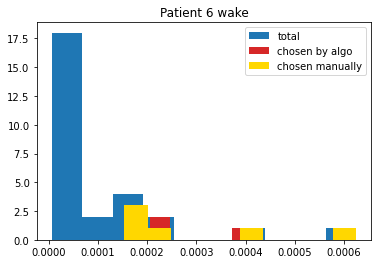

In [68]:
p = 'pat6'
s = 'wake'

patient = Patient(edf_file = paths[p][s]['path_edf'],
                 annotations =  paths[p][s]['path_ann'],
                 path_to_visual_outputs= paths[p][s]['path_visual'],
                 path_to_results= paths[p][s]['path_results'],
                 path_to_ica_matrix= paths[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 500,
                 chosen_components =[])
            
patient.quantify_annotations()

chosen_components = paths[p][s]['chosen_components']
true_components[p][s] = chosen_components 

components_vals = {}

patient.run_ica()
patient.no_channels_during_seizures_states()
patient.normalize_components()
algos, components_vals, components_scores, scores_components = deviative_choice(patient, components_vals)
algos_components[p][s] = algos 

patient.plot_selected_components_during_seizures(potentially_significant=algos, savefigures=True)

plt.hist(components_vals.values(), bins = 10, label='total')
plt.hist([components_vals[i] for i in algos], bins = 10, color='tab:red', label='chosen by algo')
plt.hist([components_vals[i] for i in chosen_components], bins = 10, color='gold', label='chosen manually')
plt.legend()
plt.title('Patient '+p[3:]+' '+s)
plt.show()

In [69]:
algos, chosen_components
 
# To record : z-score of chosen true components, z-score of components which fall withing the range
#     and corresponding names of components

(['ICA003', 'ICA005', 'ICA008', 'ICA016'],
 ['ICA006', 'ICA016', 'ICA003', 'ICA008', 'ICA001', 'ICA025'])

In [60]:

def deviative_choice(patient, components_vals, sigma = 0.8):

    per_channel_deviation_names = []
    per_channel_deviation_values  = []
    
    for channel in tqdm(patient.normalized_per_component_states):
        per_channel_deviation_names.append(channel)
        avg, stdev = get_average(patient.normalized_per_component_states[channel])
        
        span = np.max(avg) - np.min(avg)
        variance = np.var(avg)
        combined_val =  span + variance
        
        components_vals[channel] = combined_val
        per_channel_deviation_values.append(combined_val )

    per_channel_deviation_values = np.asarray(per_channel_deviation_values)
    per_channel_deviation_names = np.asarray(per_channel_deviation_names)

    indx_val = {}
    for i, val in enumerate(per_channel_deviation_values):
        indx_val[val] = i

    scores = zscore(per_channel_deviation_values) 
    
    components_scores = {}
    scores_components = {}
    if len(true_components) > 0 :
        for name, val in zip(per_channel_deviation_names, scores):
            components_scores[name] = val
            scores_components[val] = name
            
    
#     print(per_channel_deviation_names)
    chosen = list(per_channel_deviation_names[scores >= sigma])
    print("CHOSEN",chosen)

    while len(chosen) < 3:

        sorted_per_channel_deviation_values = np.sort(per_channel_deviation_values)[::-1]

        for stdev_val in sorted_per_channel_deviation_values:
            if per_channel_deviation_names[indx_val[stdev_val]] not in chosen:
                chosen.append(per_channel_deviation_names[indx_val[stdev_val]])
                print("ADDED", per_channel_deviation_names[indx_val[stdev_val]])
                break

    return chosen, components_vals, components_scores, scores_components


In [66]:
def find_best_sigma(func, patients, sigma):

    for i, p in enumerate(patients):
        fig, axs = plt.subplots(1, 2)
        for j, s in enumerate(['sleep', 'wake']):
            patient = Patient(edf_file = paths[p][s]['path_edf'],
                 annotations =  paths[p][s]['path_ann'],
                 path_to_visual_outputs= paths[p][s]['path_visual'],
                 path_to_results= paths[p][s]['path_results'],
                 path_to_ica_matrix= paths[p][s]['path_ica'],
                 precomputed_ica = True,
                 ignore_channels = True,
                 window_length = 500,
                 chosen_components =[])
            
            patient.quantify_annotations()
            
            chosen_components = paths[p][s]['chosen_components']
            true_components[p][s] = chosen_components 
            
            components_vals = {}
            
            patient.run_ica()
            patient.no_channels_during_seizures_states()
            patient.normalize_components()
            algos, components_vals, components_scores, scores_components = func(patient, components_vals, sigma=sigma)
            algos_components[p][s] = algos 

#             patient.plot_selected_components_during_seizures(potentially_significant=algos, savefigures=True)
            thr = sigma
            l = [i for i in scores_components.keys()]
            k = [i for i in components_scores.keys()]
            print("scores included",l[np.where(l>=thr)])
            print("components included", k[np.where(l>=thr)])

            for i in chosen_components:
                print(i, components_scores[i])
    
            axs[j].hist(components_vals.values(), bins = 10, label='total')
            axs[j].hist([components_vals[i] for i in algos], bins = 10, color='tab:red', label='chosen by algo')
            axs[j].hist([components_vals[i] for i in chosen_components], bins = 10, color='gold', label='chosen manually')
            axs[j].legend()
            axs[j].set_title('Patient '+p[3:]+' '+s)
            
        fig.show()

CHOSEN COMPONENTS []
Extracting EDF parameters from /data/garkots/third_package/pat07_ON_sleep/pat07_EEG_1181-export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel  PAT07_EEG_1181 with  2235 markings
Total number of markings 2235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.60it/s]

CHOSEN ['ICA006']
ADDED ICA005
ADDED ICA009


TypeError: '>=' not supported between instances of 'list' and 'float'

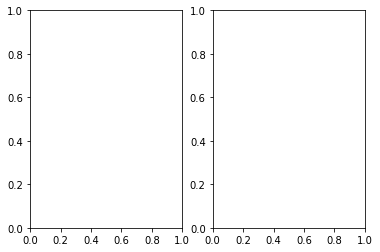

In [67]:
find_best_sigma(deviative_choice, patients=['pat7'], sigma=0.6) 

In [ ]:
def f (sigma) --> accuracy


In [ ]:
f1 (sigma) --> components - zscores

In [49]:
'ICA010', 'ICA023', 'ICA009', 'ICA006'

('ICA010', 'ICA023', 'ICA009', 'ICA006')

In [7]:
type(patient.per_component_state_during_seizures)

dict

In [8]:
patient.per_component_state_during_seizures.keys()

dict_keys(['ICA000', 'ICA001', 'ICA002', 'ICA003', 'ICA004', 'ICA005', 'ICA006', 'ICA007', 'ICA008', 'ICA009', 'ICA010', 'ICA011', 'ICA012', 'ICA013', 'ICA014', 'ICA015', 'ICA016', 'ICA017', 'ICA018', 'ICA019', 'ICA020', 'ICA021', 'ICA022', 'ICA023'])

In [13]:
len(patient.per_component_state_during_seizures['ICA000']), len(patient.per_component_state_during_seizures['ICA000'][0]) 

(1533, 1000)

In [14]:
concatenated = np.concatenate(patient.per_component_state_during_seizures['ICA016'])
concatenated.shape

(1533000,)

In [26]:
concatenated[1001], patient.per_component_state_during_seizures['ICA016'][1][1]

(0.5204072927684416, 0.5204072927684416)

In [27]:
np.max(concatenated)

31.281816254554272

In [29]:
np.where(np.asarray(patient.per_component_state_during_seizures['ICA016']) == np.max(concatenated))

(array([707]), array([947]))

In [18]:
f = [ [1,2], [3,4] ]
np.concatenate(f)

array([1, 2, 3, 4])

In [ ]:
# ['ICA010' span 29 , 'ICA023' span 22, 'ICA009' span 28, 'ICA006' span 28]